### Solving for the WCS using in focus phosim images (without transpose correction)

In this notebook we solve for a new WCS given an in focus phosim image oand an assocaited reference catalog (Gaia). This uses the Rubin DM stack and AstrometryTask

NOTE: the phosim images are transposed relative to the "correct" orientation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lsst.utils.tests
import lsst.geom
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.meas.base as measBase
from lsst.daf.persistence import Butler
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask, MagnitudeLimit
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.afw.image.utils import defineFilter
from lsst.meas.astrom import AstrometryTask

In [2]:
def makeSourceCat(bbox, distortedWcs, refObjLoader):
    """Make a source catalog by reading the position reference stars and distorting the positions
    """
    loadRes = refObjLoader.loadPixelBox(bbox=bbox, wcs=distortedWcs, filterName="phot_rp_mean")
    refCat = loadRes.refCat
    refIdKey = refCat.schema["id"].asKey()
    refRAKey = refCat.schema["coord_ra"].asKey()
    refDecKey = refCat.schema["coord_dec"].asKey()
    refCentroidKey = afwTable.Point2DKey(refCat.schema["centroid"])
    refFluxRKey = refCat.schema["phot_rp_mean_flux"].asKey()

    sourceSchema = afwTable.SourceTable.makeMinimalSchema()
    measBase.SingleFrameMeasurementTask(schema=sourceSchema)  # expand the schema
    sourceCat = afwTable.SourceCatalog(sourceSchema)
    sourceCentroidKey = afwTable.Point2DKey(sourceSchema["slot_Centroid"])
    sourceIdKey = sourceSchema["id"].asKey()
    sourceRAKey = sourceSchema["coord_ra"].asKey()
    sourceDecKey = sourceSchema["coord_dec"].asKey()
    sourceInstFluxKey = sourceSchema["slot_ApFlux_instFlux"].asKey()
    sourceInstFluxErrKey = sourceSchema["slot_ApFlux_instFluxErr"].asKey()

    sourceCat.reserve(len(refCat))
    for refObj in refCat:
        src = sourceCat.addNew()
        src.set(sourceIdKey, refObj.get(refIdKey))
        src.set(sourceRAKey, refObj.get(refRAKey))
        src.set(sourceDecKey, refObj.get(refDecKey))

        src.set(sourceCentroidKey, refObj.get(refCentroidKey))
        src.set(sourceInstFluxKey, refObj.get(refFluxRKey))
        src.set(sourceInstFluxErrKey, refObj.get(refFluxRKey)/100)
    return sourceCat

In [3]:
def plotDistances(matches):
    '''Plot histogram of match separations'''
    distances = np.array([match.distance for match in results.matches])
    distances *= 180.*3600./np.pi
    plt.hist(distances)
    plt.xlabel("Distance (arcsecond)")
    plt.ylabel("Number")

In [4]:
# Read in Gaia data and phosim images (from different butlers)
# data set contains infocus 9006000 and intra/extra 9006001/9006002 focus images
# NOTE will read S11 R22 as should be same as boresite of telescope (then extend)

refCatDir = '/astro/users/ajc26/epycuser/LSST-Commissioning/aoc/gaia_refcat'
butler = Butler(refCatDir)
refObjLoader = LoadIndexedReferenceObjectsTask(butler=butler)

data_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_gt11/input/rerun/run1'
butlerISR = Butler(data_dir)
dataId = {'visit': 9006000, 'filter': 'g', 'raftName': 'R22', 'detectorName': 'S11'}
raw = butlerISR.get('postISRCCD', dataId=dataId)
rawDataRef = butlerISR.dataRef('postISRCCD', **dataId)

In [5]:
print(raw.getWcs())
print(raw.getWcs().getCdMatrix())

FITS standard SkyWcs:
Sky Origin: (233.017336, -4.447088)
Pixel Origin: (2026.5, 2000.5)
Pixel Scale: 0.2 arcsec/pixel
[[-5.55555556e-05  0.00000000e+00]
 [ 0.00000000e+00  5.55555556e-05]]


In [6]:
# Phosim images are transposed so we flip the WCS and we (at the catalog level swamp x,y)
from lsst.afw.geom import makeFlippedWcs
flippedWcs = makeFlippedWcs(raw.getWcs(), flipLR=True, flipTB=False, center=raw.getBBox().getCenter())
raw.setWcs(flippedWcs)

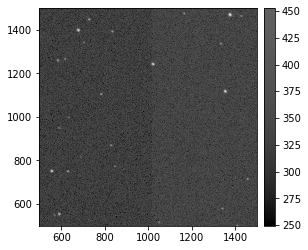

In [7]:
#Display image
import lsst.afw.display as afwDisplay
afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(raw[500:1500,500:1500])


In [8]:
# create a simple gaussian psf for source detection
def gkern(l=3, sig=0.5):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

# Create a PSF object from a NumPy array of the PSF image.  This should have odd dimensions, and be
psf_array = gkern(l=11, sig=2)
psf_array = psf_array.astype(np.float64)
psf_image = lsst.afw.image.ImageD(psf_array)
psf_kernel = lsst.afw.math.FixedKernel(psf_image)
psf = lsst.meas.algorithms.KernelPsf(psf_kernel)

In [9]:
#Use DM tasks to run: detection, measure using the simple PSF (no deblending)
#From Merlin: It's usually a good idea to construct all Tasks before using any of them, mostly
# to define the full schema of any catalogs we'll produce up front.

schema = lsst.afw.table.SourceTable.makeMinimalSchema()

configDetection = SourceDetectionTask.ConfigClass()
configDetection.thresholdValue =60   # detection threshold in units of thresholdType
configDetection.thresholdType = "stdev"#"stdev"   # units for thresholdValue
configDetection.minPixels = 10
detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=configDetection)


measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema)
table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table

#create copy of image 
from copy import deepcopy
exposure = deepcopy(raw)
exposure.setPsf(psf)

# Run the detect the measure tasks
detect_result = detect.run(table, exposure)

catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
measure.run(catalog, exposure)

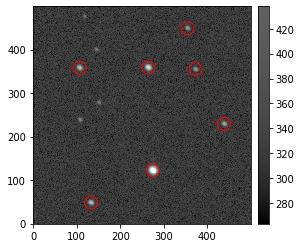

In [10]:
#overlay centroids of detections on image
xcen = catalog['slot_Centroid_x']
ycen = catalog['slot_Centroid_y']

afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(raw[0:500,0:500])
for _x, _y in zip(xcen, ycen):
   afw_display.dot('o', _x, _y, size=15, ctype='red')

In [11]:
# astrometry task uses slot_centroid_x for positions - swap x and y as images are transposed
tmp = catalog['slot_Centroid_y'].copy()
catalog['slot_Centroid_y'] = catalog['slot_Centroid_x']
catalog['slot_Centroid_x'] = tmp

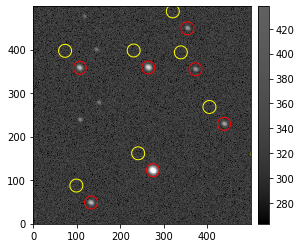

In [12]:
# Overlay x and y Gaia positions (from phosim WCS)
#Create a BBOX for the image and extract the Gaia catalog for that BBox and WCS
gaiaCat = makeSourceCat(exposure.getBBox(), exposure.getWcs(), refObjLoader)
xcen = catalog['slot_Centroid_x']
ycen = catalog['slot_Centroid_y']

fluxLimit = 100000
xcenG = gaiaCat['slot_Centroid_x'][gaiaCat['slot_ApFlux_instFlux'] > fluxLimit]
ycenG = gaiaCat['slot_Centroid_y'][gaiaCat['slot_ApFlux_instFlux'] > fluxLimit]
afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(raw[0:500,0:500])
for _x, _y in zip(xcen, ycen):
   afw_display.dot('o', _y, _x, size=15, ctype='red')

for _x, _y in zip(xcenG, ycenG):
   afw_display.dot('o', _y, _x, size=15, ctype='yellow')

### Calculate WCS from detected sources


In [13]:
# Check Gaia catalog by extracting and printing a few points
import lsst.afw.coord as afwCoord
import lsst.geom as geom
expCenter = exposure.getWcs().pixelToSky(lsst.geom.Box2D(exposure.getBBox()).getCenter())
cat = refObjLoader.loadSkyCircle(expCenter, geom.Angle(1., geom.degrees), filterName='phot_rp_mean')
cat.refCat.asAstropy()[0:5]


id,coord_ra,coord_dec,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_fluxErr,phot_bp_mean_fluxErr,phot_rp_mean_fluxErr,coord_raErr,coord_decErr,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,pm_flag,parallax,parallaxErr,parallax_flag,astrometric_excess_noise,phot_variable_flag
,rad,rad,nJy,nJy,nJy,nJy,nJy,nJy,rad,rad,d,rad,rad,rad / yr,rad / yr,,rad,rad,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float32,float32,bool,float64,float64,bool,float64,str52
4401402839067325056,4.064006566143465,-0.0785701282922876,826558.3702127271,586123.136881632,1159786.1408002798,671.0930812329242,3821.2202209976663,5057.717191822604,3.103477e-10,3.0191483e-10,57205.87440946643,1.9847239457467886e-08,-3.203984575929499e-08,6.7765094e-10,6.246255e-10,False,2.7851851937216413e-09,3.875947703973588e-10,False,0.08698245261224606,NOT_AVAILABLE
4401402293607945728,4.0631802966203105,-0.07922456068154617,39896.49333528013,20617.57986349432,66128.88759872357,269.3390873130959,1153.387938481198,2304.0049875325753,2.2465125e-09,2.1859239e-09,57205.87440946643,-9.531300754646982e-09,5.51233174419837e-09,5.529479e-09,4.9710156e-09,False,-2.9620213491964053e-09,2.662084367760661e-09,False,1.1973818168808303,NOT_AVAILABLE
4401418236525510656,4.064096018197572,-0.07599402826625569,28279.187970900293,7545.145583596309,71764.04863262564,250.22919210769945,1467.496985581349,2878.907321849603,3.4450895e-09,2.7486466e-09,57205.87440946643,-2.8274313314543924e-08,-4.941443958280925e-09,7.616014e-09,6.778281e-09,False,3.5116939877964894e-09,3.8226848223266554e-09,False,0.0,NOT_AVAILABLE
4401402632908894464,4.063518142504037,-0.07858078181653617,490008.40008130256,369003.0779748424,650411.3041075119,579.5305947481006,3214.9818470469236,4249.59635813512,4.6178314e-10,3.7571474e-10,57205.87440946643,-7.338094890067618e-08,-3.3385679036601073e-08,1.0532115e-09,8.178264e-10,False,2.6079766975851476e-09,5.482104644585743e-10,False,0.2503052634324574,NOT_AVAILABLE
4401422836436896384,4.06222079741538,-0.07442070177602465,29420.205943057557,25501.511068193595,52162.91018582051,285.2313481314647,5051.416624117162,3761.227319351773,3.4047694e-09,2.9618654e-09,57205.87440946643,-5.75984584631794e-08,-1.4314895603840253e-08,7.919946e-09,7.003484e-09,False,-2.209075622779626e-09,3.718134313870905e-09,False,0.0,NOT_AVAILABLE


In [14]:
# match and fit wcs using AstrometryTask (notes from Merlin)
astromConfig = AstrometryTask.ConfigClass()
# Pick your retarget here if necessary
# astromConfig.wcsFitter.retarget(FitAffineWcsTask)
# astromConfig.wcsFitter.retarget(FitTanSipWcsTask)
# astromConfig.referenceSelector.doMagLimit = False
#    You probably *do* want to do a mag limit, because your donuts are
#    unlikely to go as deep as GAIA, and if you have too much choice the matcher
#    will always succeed, but finding false matches with huge scatter.
magLimit = MagnitudeLimit()
magLimit.minimum = 1
magLimit.maximum = 15
astromConfig.referenceSelector.magLimit = magLimit
astromConfig.referenceSelector.magLimit.fluxField = "phot_rp_mean_flux"
astromConfig.matcher.minMatchedPairs = 4
astromConfig.matcher.maxRotationDeg = 5.99
astromConfig.matcher.maxOffsetPix = 1000
astromConfig.wcsFitter.order = 3
astromConfig.wcsFitter.numRejIter = 0
astromConfig.wcsFitter.maxScatterArcsec = 15

# this is a bit sleazy (as RHL would say) but I'm just forcing the exposure
# to have the same name as the one in the Gaia catalog for now
referenceFilterName = 'phot_rp_mean'
defineFilter(referenceFilterName, 656.28)
referenceFilter = afwImage.filter.Filter(referenceFilterName)
exposure.setFilter(referenceFilter)

solver = AstrometryTask(config=astromConfig, refObjLoader=refObjLoader, schema=schema,)
results = solver.run(sourceCat=catalog, exposure=exposure,)

In [15]:
print (exposure.getWcs())
print (exposure.getWcs().getCdMatrix())

FITS standard SkyWcs:
Sky Origin: (233.009691, -4.449669)
Pixel Origin: (1867.16, 1985.99)
Pixel Scale: 0.200173 arcsec/pixel
[[ 5.56019115e-05 -3.57252677e-09]
 [ 7.19984600e-09  5.56051642e-05]]


In [16]:
#original phosim WCS
print (raw.getWcs())
print (raw.getWcs().getCdMatrix())

FITS standard SkyWcs:
Sky Origin: (233.017336, -4.447088)
Pixel Origin: (2044.5, 2000.5)
Pixel Scale: 0.2 arcsec/pixel
[[5.55555556e-05 0.00000000e+00]
 [0.00000000e+00 5.55555556e-05]]


0.009368967383764111


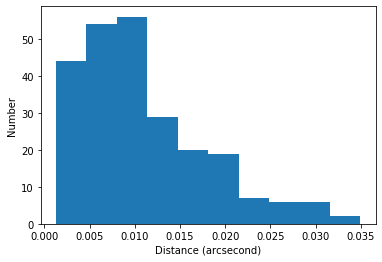

In [17]:
print (results.scatterOnSky.asArcseconds())
plotDistances(results.matches)

In [18]:
#Get x y from reference catalog using the derived WCS
solvedPositions = refObjLoader.loadPixelBox(bbox=exposure.getBBox(), wcs=exposure.getWcs(), 
                                            filterName="phot_rp_mean")
solvedRefCat = solvedPositions.refCat
solvedRefCat.asAstropy()[0:5]

id,coord_ra,coord_dec,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_fluxErr,phot_bp_mean_fluxErr,phot_rp_mean_fluxErr,coord_raErr,coord_decErr,epoch,pm_ra,pm_dec,pm_raErr,pm_decErr,pm_flag,parallax,parallaxErr,parallax_flag,astrometric_excess_noise,phot_variable_flag,centroid_x,centroid_y,hasCentroid
,rad,rad,nJy,nJy,nJy,nJy,nJy,nJy,rad,rad,d,rad,rad,rad / yr,rad / yr,,rad,rad,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float32,float32,bool,float64,float64,bool,float64,str52,float64,float64,bool
4401352673849287296,4.068690572220802,-0.07912865975389413,71184.0537450721,49761.619166097815,105602.74088734642,274.9788330701666,1612.9959668665174,2193.9717099125787,1.3579002e-09,1.207632e-09,57205.87440946643,-6.2311094133427e-08,1.0234633355309151e-08,2.9941394e-09,2.70631e-09,False,3.2589225573123093e-10,1.8026637738116755e-09,False,0.381509790392664,NOT_AVAILABLE,3823.134495266384,473.79166852537037,True
4401406244977994112,4.06564149794198,-0.07609873755568372,204277.5852896631,131871.1269827519,323915.2504025453,417.66265562179007,4598.99194050733,3365.2852459505657,7.8998846e-10,6.019088e-10,57205.87440946643,-2.0925434349454646e-08,-2.979079784627661e-08,1.9226891e-09,1.5691991e-09,False,1.0593299600504559e-09,8.067371107338737e-10,False,0.12968600907381655,NOT_AVAILABLE,691.0822445599608,3596.1580451473124,True
4401404728852969344,4.064946289272802,-0.07761153105192865,151409.56224573555,92803.83041010449,266125.2489115569,370.4817653142217,4032.6347665732924,6717.07034368341,8.591261e-10,6.853591e-10,57205.87440946643,-1.3989150409327518e-07,1.6348152639871238e-08,2.0578892e-09,1.7085839e-09,False,1.2618482979890253e-09,9.569063153042556e-10,False,0.0,NOT_AVAILABLE,-23.17059150601517,2037.3941948934398,True
4401399952849301632,4.064884729779692,-0.07856711639954565,38262.24072952191,17616.444436342546,70186.8734597716,228.3526528269066,2889.9177513579443,2915.073810837447,2.417505e-09,2.7878753e-09,57205.87440946643,-2.7189906296252596e-08,-2.5878003445869464e-09,6.121081e-09,6.2598446e-09,False,5.52416587147423e-09,2.9050572857330505e-09,False,0.0,NOT_AVAILABLE,-86.39629988182446,1052.7865441243252,True
4401352708209027072,4.068928941898863,-0.07909981557728317,43335.69378534903,24863.35675612288,59914.675600267416,190.2194979143745,2073.85866685597,2832.289972862408,1.910864e-09,1.6656844e-09,57205.87440946643,-7.718898314197839e-09,-5.122780218226571e-08,4.197434e-09,3.745312e-09,False,-9.843206966226292e-10,2.597407818922025e-09,False,0.0,NOT_AVAILABLE,4067.9876708914026,503.4886871955573,True


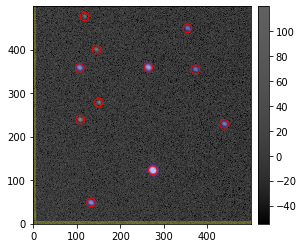

In [19]:
#display solved positions (note transpose)
xcen = solvedRefCat['centroid_x']
ycen = solvedRefCat['centroid_y']

afw_display = afwDisplay.Display(backend='matplotlib')
afw_display.scale('asinh', 'zscale')
afw_display.mtv(exposure[0:500,0:500])
for _x, _y in zip(xcen, ycen):
   afw_display.dot('o', _y, _x, size=10, ctype='red')